# Khai báo thư viện

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Đọc và mô tả dữ liệu

In [3]:
path='Customer_Sentiment.csv'

In [4]:
df = pd.read_csv(path)
df

,customer_id,gender,age_group,region,product_category,purchase_channel,platform,customer_rating,review_text,sentiment
0,1,male,60+,north,automobile,online,flipkart,1,very disappointed with the quality.,negative
1,2,other,46-60,central,books,online,swiggy instamart,5,fast delivery and great packaging.,positive
2,3,female,36-45,east,sports,online,facebook marketplace,1,very disappointed with the quality.,negative
3,4,female,18-25,central,groceries,online,zepto,2,product stopped working after few days.,negative
4,5,female,18-25,east,electronics,online,croma,3,neutral about the quality.,neutral
...,...,...,...,...,...,...,...,...,...,...
24995,24996,female,36-45,south,beauty,online,lenskart,1,very disappointed with the quality.,negative
24996,24997,other,60+,central,automobile,online,flipkart,5,"amazing experience, highly recommend!",positive
24997,24998,male,18-25,south,beauty,online,ajio,4,fast delivery and great packaging.,positive
24998,24999,female,26-35,central,automobile,online,snapdeal,5,great value for money.,positive


* customer_id: Mã khách hàng
* gender: giới tính khách hàng
* age_group: nhóm tuổi khách hàng
* region: khu vực sống của khách hàng
* product_category: loại hàng mua
* purchase_channel: cách thức mua hàng(chỉ có 1 value 'online')
* platform: Nền tảng mua sắm
* customer_rating: số sao đánh giá của khách hàng
* review_text: bình luận của khách hàng
* sentiment: Cảm xúc khách hàng

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       25000 non-null  int64 
 1   gender            25000 non-null  object
 2   age_group         25000 non-null  object
 3   region            25000 non-null  object
 4   product_category  25000 non-null  object
 5   purchase_channel  25000 non-null  object
 6   platform          25000 non-null  object
 7   customer_rating   25000 non-null  int64 
 8   review_text       25000 non-null  object
 9   sentiment         25000 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.9+ MB


In [6]:
df.nunique().sort_values()

purchase_channel        1
gender                  3
sentiment               3
region                  5
customer_rating         5
age_group               5
product_category        9
review_text            15
platform               20
customer_id         25000
dtype: int64

In [7]:
df = df.drop(['purchase_channel', 'customer_id'], axis=1)
df.head()

,gender,age_group,region,product_category,platform,customer_rating,review_text,sentiment
0,male,60+,north,automobile,flipkart,1,very disappointed with the quality.,negative
1,other,46-60,central,books,swiggy instamart,5,fast delivery and great packaging.,positive
2,female,36-45,east,sports,facebook marketplace,1,very disappointed with the quality.,negative
3,female,18-25,central,groceries,zepto,2,product stopped working after few days.,negative
4,female,18-25,east,electronics,croma,3,neutral about the quality.,neutral


# Tiền sử lí dữ liệu

In [8]:
continuous_vars = ['customer_rating']
scaler = StandardScaler()
df_continuous = pd.DataFrame(scaler.fit_transform(df[continuous_vars]), columns=continuous_vars)
df_continuous.head()

,customer_rating
0,-1.425640
1,1.422108
2,-1.425640
3,-0.713703
4,-0.001766


In [9]:
word = ['product is okay, nothing special.',
        'delivery was fine, product is decent.']

# Điều kiện dòng neutral
neutral_mask = df['sentiment'] == 'neutral'

# Điều kiện review khớp với word list
positive_mask = df['review_text'].isin(word)

# Gán positive cho các dòng neutral mà review nằm trong list word
df.loc[neutral_mask & positive_mask, 'sentiment'] = 'positive'

# Gán negative cho các dòng neutral còn lại
df.loc[neutral_mask & (~positive_mask), 'sentiment'] = 'negative'

In [10]:
import re
def clean_text(t: str) -> str:
    if not isinstance(t, str): #kiểu tra nếu dữ liệu k phải string hay rỗng thì trả về khoảng trắng
        return ''
    t = t.lower() #chuyển thành chữ viết thường
    t = re.sub(r'[^a-z\s]', ' ', t) #Đây là mẫu Regex Tìm tất cả các ký tự KHÔNG phải là chữ cái thường (a-z) hoặc khoảng trắng, và thay thế chúng bằng dấu cách
    t = re.sub(r'\s+', ' ', t).strip() #tìm những khoảng trắng liên tiếp và gán bằng 1 khoảng trắng duy nhất
    return t

In [11]:
df['review_text'] = df['review_text'].apply(clean_text) #gán lại

In [12]:
df['sentiment'] = df['sentiment'].map(lambda x: 1 if x == 'positive' else 0)

In [13]:
cat_vars = ['gender','age_group','region', 'product_category','platform']
le = LabelEncoder()
df_cat = df[cat_vars].apply(le.fit_transform)
df_cat.head()

,gender,age_group,region,product_category,platform
0,1,4,2,0,6
1,2,3,0,2,17
2,0,2,1,7,5
3,0,0,0,5,19
4,0,0,1,3,4


In [14]:
df1 = pd.concat([df_continuous, df_cat, df['sentiment']], axis=1)
df1.head()

,customer_rating,gender,age_group,region,product_category,platform,sentiment
0,-1.425640,1,4,2,0,6,0
1,1.422108,2,3,0,2,17,1
2,-1.425640,0,2,1,7,5,0
3,-0.713703,0,0,0,5,19,0
4,-0.001766,0,0,1,3,4,0


In [15]:
tfidf = TfidfVectorizer(max_features=5000,       # giới hạn số features cho nhẹ
    ngram_range=(1, 2))
x=tfidf.fit_transform(df['review_text'])


In [16]:
df[['customer_rating', 'gender']].values

array([[1, 'male'],
       [5, 'other'],
       [1, 'female'],
       ...,
       [4, 'male'],
       [5, 'female'],
       [3, 'male']], shape=(25000, 2), dtype=object)

In [17]:
from scipy.sparse import hstack
dl=df1.drop('sentiment', axis=1)
X_final = hstack([x, dl])

In [18]:
y=df1['sentiment']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình

In [20]:
def evaluate_clf(model,model_name):
    y_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_test_proba[:,1])

    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(15,4)
    plt.tight_layout()
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axs[0])
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axs[1])
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axs[2])
    axs[0].set_title('Precision-Recall curve')
    axs[1].set_title('ROC curve')

    eval_dict = {'modelname':model_name,'accuracy':accuracy,
                'precision':precision,'recall':recall,'f1':f1,'roc_auc':auc}
    return eval_dict

model_metrics = pd.DataFrame(columns=['modelname', 'accuracy', 'precision','recall','f1', 'roc_auc'])

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2608
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



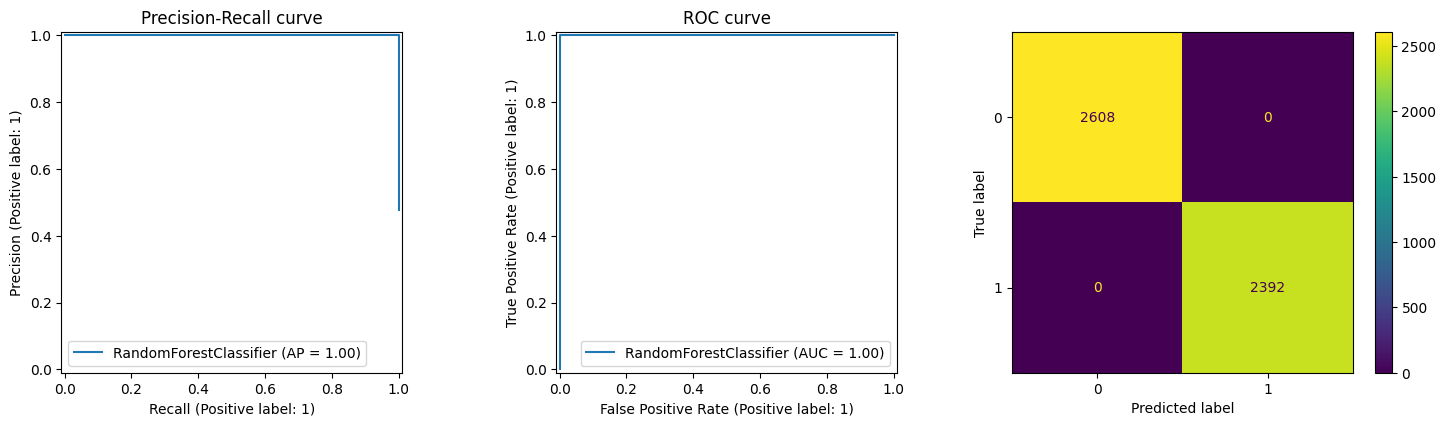

In [23]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
metrics = evaluate_clf(model,'Random Forest')


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      2608
           1       0.93      0.98      0.95      2392

    accuracy                           0.95      5000
   macro avg       0.95      0.96      0.95      5000
weighted avg       0.96      0.95      0.95      5000



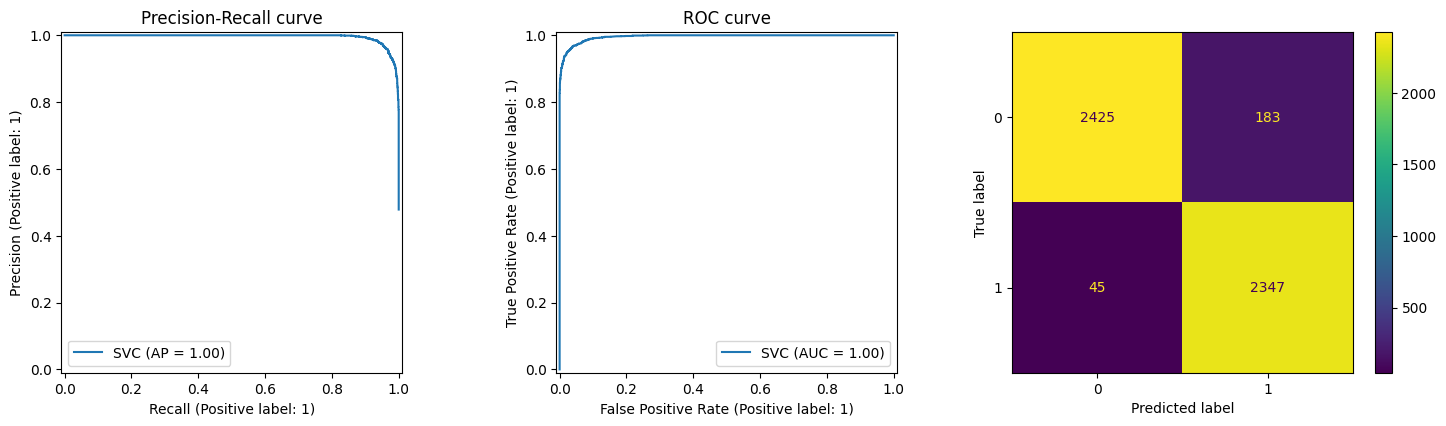

In [ ]:
svc = SVC(probability=True, max_iter=40)
svc.fit(X_train, y_train)
metrics = evaluate_clf(svc,'Suport Vector Machine')
